# Optimització - Linear regression

En estadística, la **regressió lineal** és un enfocament lineal per modelar la relació entre una resposta escalar (o variable dependent) i una o més variables explicatives (o variables independents).

En regressió lineal, les relacions es modelen mitjançant funcions lineals on els paràmetres del model s’estimen a partir de les dades. 
Aquests models s'anomenen models lineals. 

Suposem que treballem amb un conjunt de dades $ \{y_{i}, x_{i_1}, \ldots, x_{i_m} \}_{i = 1}^{n}$ de $n$ unitats. 

Un **model de regressió lineal** assumeix que la relació entre la variable dependent $y$ i el vector $p$ dels regressors $x$ és lineal. 
Així, el model pren la forma:
$${\displaystyle y_{i}=\beta _{0}+\beta _{1}x_{i_1}+\cdots +\beta _{p}x_{i_p},\qquad i=1,\ldots ,n,}$$

In [4]:
# Comprovem que autograd estigui instal·lat
if __name__ == '__main__':
    try:
        import autograd
    except:
        print('No s\'ha detectat autograd instal·lat')
        if input('Vols instalar autograd? [s/n]').strip().lower() == 's':
            !pip3 install --user -U autograd
            !pip install --user -U autograd
        else:
            print('Abans de continuar instal·la autograd')

In [3]:
pip install autograd --upgrade


The following command must be run outside of the IPython shell:

    $ pip install autograd --upgrade

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [5]:
from plot_utils import *

import autograd.numpy as np
from autograd import elementwise_grad as grad, value_and_grad
import matplotlib.pyplot as plt
import pandas as pd
import random

if __name__ == '__main__':
    from IPython.display import display
    
    %matplotlib inline

No es permet l'ús de cap llibreria o funció que no estigui ja importat, sigui aquí o més abaix en el notebook.

Per Kaggle es permet l'ús d'altres llibreries/funcions sempre i quan únicament es facin servir pel processament de dades, i no pel model i/o predicció.

# AutoGrad

En la part anterior, donada una funció havíem de definir també la funció que retorna el seu gradient.

En aquesta pràctica, però, veurem que mitjançant l'ús de la llibreria **AutoGrad**, això no és necessari.

Consideren les següents funcions:

In [6]:
def f1(x):
    return x**2

def f2(x):
    x, y = x[0], x[1]
    return x**2 + y**2

def f3(x):
    x, y, z = x[0], x[1], x[2]
    return (100 * (y - x**2)**2 + (1 - x)**2) + (100 * (z - y**2)**2 + (1 - y)**2)

Donada la funció `f1`, podem fàcilment derivar el seu gradient, que és $2x$.

Definim-lo manualment:

In [7]:
def grad_f1_manual(x):
    return 2*x

Ara, obtinguem la funció gradient a partir d'autograd:

In [8]:
grad_f1 = grad(f1)

Podem comprovar que **les dues donen el mateix valor de gradient evaluat en un punt $x$**.

In [9]:
x0 = np.asarray([1023.0])
print('Calcul manual gradient: df1\'(x0) = {}'.format(grad_f1_manual(x0)[0]))
print('Autograd: df1\'(x0) = {}'.format(grad_f1(x0)[0]))

assert np.allclose(grad_f1_manual(x0), grad_f1(x0)) 

Calcul manual gradient: df1'(x0) = 2046.0
Autograd: df1'(x0) = 2046.0


També podem utilitzar `value_and_grad` per obtenir directament amb la **imatge de la funció i el seu gradient en un punt $x$**:

In [10]:
val_grad_f1 = value_and_grad(f1)
print(val_grad_f1(x0))

value, gradient = val_grad_f1(x0)
assert np.allclose(value, f1(x0))
assert np.allclose(gradient, grad_f1(x0))

(array([1046529.]), array([2046.]))


Inclús podem aplicar `grad` sobre un altre `grad` per obtenir la 2a derivada (o Hessià en multiples dimensions).

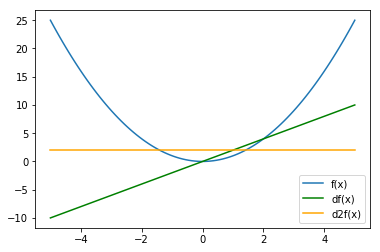

In [11]:
grad_f1 = grad(f1) # df(x) = 2 * x
grad2_f1 = grad(grad_f1) # d2f(x) = 2

if __name__ == '__main__':
    x = np.linspace(-5, 5, 100)
    plt.plot(x, f1(x), label = 'f(x)')
    plt.plot(x, grad_f1(x), color='green', label = 'df(x)')
    plt.plot(x, grad2_f1(x), color='orange', label = 'd2f(x)')
    plt.legend()

# Descens del gradient

**El primer pas serà implementar la mateixa funció `gradient_descend` que havieu fet en la part anterior, però ara mitjançant l'ús de la llibreria `autograd` i fent-la multidimensional.**

Aquesta funció hauria d'executar sense problemes, i donar el mínim, per les tres funcions `f1`, `f2` i `f3` definides més adalt, de 1, 2 i 3 dimensions respectivament. Però, també haurà de funcionar per les següents parts de la pràctica, amb 100 o més dimensions.

In [45]:
# Per utilitzar aquesta llibreria cal tenir instalar el paquet tqdm
from tqdm import tqdm_notebook
import numpy as np
def human_format(num):
    """
    Funció auxiliar per formatar els nombres

    100    -> 100.00
    2100   -> 2.10K
    342100 -> 342.10K
    etc.    
    
    :param num: Nombre a formatar
    :return: String amb el nombre formatat
    """
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

def gradient_descend(f, x0, alpha, eps=1e-6, max_iter=1000, print_iters=1000):
    """
    Aquesta funció implementa l'algorisme de descens pel gradient, és a dir,
    donat un punt inicial, la funció de la que calculem el gradient i el pas, 
    intenta trobar el mínim de la funció seguint el gradient en direcció oposada.
    
    Pel criteri d'aturada, considerarem si ||x^{k+1} - x^k|| < eps, és a dir
    si la norma de la diferència és més petita que eps.
    
    Cada print_iters cal mostrar el resultat actual en la següent forma:
        "{}/{:.2f}".format(human_format(itr), float(valor_de_f_en_x))
    És dir, un missatge que inclogui la iteració i el valor de f en el punt
    
    :param f: Funció a minimitzar
    :param x0: Punt inicial
    :param alpha: Pas de cada iteració
    :param eps: Moviment mínim realitzat abans de parar
    :param max_epochs: Iteracions màximes a realitzar
    :param print_iters: Numero d'iteracions per printar resultats
    :return: La funció retornarà el punt on es troba el mínim
    """
       
    i=0
    val_grad_f = value_and_grad(f)
    while i<max_iter:
        val_grad=val_grad_f(x0)
        #Normalizamos el gradiente para evitar overflow
        aux=np.dot(val_grad[1]/ np.linalg.norm(val_grad[1]),alpha)
        if np.linalg.norm(aux) < eps:
             return x0
        else:
            x0-=aux
            i+=1
        if (i % print_iters) == 0:
            print("{}/{:.2f}".format(human_format(i), float(val_grad[0])))
            
    return x0


Busquem el mínim de cadascuna de les funcions:

In [13]:
if __name__ == '__main__':
    x0 = np.array([4.0])
    xm = gradient_descend(f1, x0, 0.01, 1e-6, 10000) # ~ @1s
    print(f'f1({xm}) = {f1(xm)}')

f1([4.98237376e-05]) = [2.48240483e-09]


In [14]:
if __name__ == '__main__':
    x0 = np.array([4.0, 5.1])
    xm = gradient_descend(f2, x0, 0.01, 1e-6, 10000) # ~ @1s
    print(f'f2({xm}) = {f2(xm)}')

f2([3.06804779e-05 3.91176093e-05]) = 2.4714790816465446e-09


In [46]:
if __name__ == '__main__':
    x0 = np.array([4.0, 5.1, 4.4])
    xm = gradient_descend(f3, x0, 0.01, 1e-6, 50000) # ~ @30s
    print(f'f3({xm}) = {f3(xm)}')

1.00K/1.66
2.00K/1.49
3.00K/1.32
4.00K/1.15
5.00K/0.98
6.00K/0.82
7.00K/0.66
8.00K/0.51
9.00K/0.37
10.00K/0.25
11.00K/0.16
12.00K/0.09
13.00K/0.05
14.00K/0.03
15.00K/0.02
16.00K/0.02
17.00K/0.02
18.00K/0.02
19.00K/0.02
20.00K/0.02
21.00K/0.02
22.00K/0.02
23.00K/0.02
24.00K/0.02
25.00K/0.02
26.00K/0.02
27.00K/0.02
28.00K/0.02
29.00K/0.02
30.00K/0.02
31.00K/0.02
32.00K/0.02
33.00K/0.02
34.00K/0.02
35.00K/0.02
36.00K/0.02
37.00K/0.02
38.00K/0.02
39.00K/0.02
40.00K/0.02
41.00K/0.02
42.00K/0.02
43.00K/0.02
44.00K/0.02
45.00K/0.02
46.00K/0.02
47.00K/0.02
48.00K/0.02
49.00K/0.02
50.00K/0.02
f3([0.99870267 0.98805617 0.98553371]) = 0.017497637837674974


# Linear regression

Cas simple: **Donat un conjunt de punts (X, Y) 2D, podem trobar la recta que minimitza la distància entre aquesta i tots els punts?**

Recordatori: 

Per tal de definir una recta necesitem dos punts $(x_0, y_0)$ i $(x_1, y_1)$. A partir d'aquests dos punts podem definir la recta com:

$$y={\frac {y_{1}-y_{0}}{x_{1}-x_{0}}} (x-x_{0}) +y_{0} = m \cdot x + n$$

In [ ]:
if __name__ == '__main__':
    # Lectura de les dades
    df = pd.read_csv('data/slr05.csv', index_col=0)
    display(df.head())

    # Visualització de les dades
    plt.figure(figsize = (10, 10))
    plt.scatter(df['X'], df['Y'])
    plt.xlabel('Fires per 1000 housing units')
    plt.ylabel('Thefts per 1000 population')
    plt.title('Fire and Theft in Chicago')

    # Possibles linies
    # Parametres plt.plot: (x0, x1), (y0, y1)
    plt.plot((0, 40), (0, 140), color='#ff0000')
    plt.plot((0, 40), (0, 120), color='#ff0000')
    plt.plot((0, 40), (10, 110), color='#ff0000')
    plt.plot((0, 40), (20, 70), color='#ff0000')

Per ara, donat que estem a 2D, podem visualitzar l'error, és a dir la distància respecte aquesta recta. Però tot i així és impossible que poguem visualitzar, d'entre les infinites línies possibles, la que s'ajusta millor a les dades.

**Necessitem un algorisme que la trobi automàticament,** però primer visualitzem l'error de cadascuna de les anteriors rectes:

In [ ]:
if __name__ == '__main__':
    for x1, y1, y0 in ((40, 140, 0), (40, 120, 0), (40, 110, 10), (40, 70, 20)):
        plt.figure()
        # Visualització de les dades
        plt.scatter(df['X'], df['Y'])
        plt.xlabel('Fires per 1000 housing units')
        plt.ylabel('Thefts per 1000 population')
        plt.title(f'Fire and Theft in Chicago, y = {y0} + x * {(y1 - y0) / x1:.2f}')

        # Visualització de la recta
        plt.plot((0, x1), (y0, y1), color='#ff0000')

        # Definció de la recta
        f = lambda x: (y1 - y0) / x1 * x + y0

        # Visualització de l'error per cada punt
        for _, (x, y) in df.iterrows():
            y_pred = f(x)
            plt.plot((x, x), (y, y_pred), color='b', alpha=0.2)

**Com definim un model que automàticament trobi aquesta recta?**

Primer de tot, assumim que nosaltres tenim unes dades de les quals dispossem els valors de $x$ i els corresponents valors de $y$. Per exemple, les dades anteriors.

1. Necessitem definir matemàticament una recta
$$ r: \hat{y} = m \cdot x + n $$
On $x$ és un punt que volem evaluar, $\hat{y}$ és la imatge obtinguda en el punt $x$, i $m$, $n$ són els paràmetres que defineixen la recta. Idealment, voldríem trobar aquelles $m$, $n$ que, per tot punt $x$ tinguéssim una $\hat{y}$ tal que $\hat{y}=y$.

2. Hem de mesurar l'error que estem cometent cada cop que provem una $m$, $n$ diferents (al que anomenarem *loss* del model). Per exemple, podríem definir l'error com a la distància entre el punt $y$ que hauria de ser i el $\hat{y}$ que ens dona el model:
$$\mathbb{L} = \sqrt{(y - \hat{y})^2}$$

3. Ara el que volem fer és trobar els valors de $m$, $n$ tal que $\mathbb{L}=0$. Si parem atenció a la funció definida per $\mathbb{L}$, veurem que efectivament $0$ és el mínim d'aquesta. Per tant, tot el que hem de fer és minimitzar la funció definida per
$$\mathbb{L} = \sqrt{(y - (m \cdot x + n))^2}$$

Per simplificar una mica el problema, unirem les variables que volem optimitzar $m,n$ en una de sola: $w$. Per fer-ho, expandirem la fòrmula anterior a:
$$\tilde{x} = (1, x), w = (n, m)$$

$$\mathbb{L} = \sqrt{(y - \tilde{x} \cdot w)^2}$$

On $\tilde{x}$ és un vector format per un $1$ i a continuació el valor de $x$ original. De forma que $\tilde{x} \cdot w = (1, x) \cdot (n, m) = n + x\cdot m = m\cdot x + n$ (producte escalar).

In [ ]:
def add_bias(X):
    """
    Funció que donada el vector x crea el vector x', afegint una columna d'1's al davant.
    Per exemple, si X és
        [
            [1, 2, 5, 1, 5, 7],
            [9, 4, 2, 4, 6, 1],
            ...
            [5, 3, 1, 4, 5, 7]
        ]
    El retorn de la funció serà la matriu
        [
            [1, 1, 2, 5, 1, 5, 7],
            [1, 9, 4, 2, 4, 6, 1],
            ...
            [1, 5, 3, 1, 4, 5, 7]
        ]
    
    *Sense bucles*
    
    :param X: Matriu on cada fila és una dada i cada columna una característica
    :return: Mateixa matriu amb una columna de 1s davant
    """
    raise NotImplementedError()

def linear_regression(x, w):
    """
    Donat un punt i els parameters del model prediu el valor, implementant el càlcul de
    la regressió lineal:
            y' = w0 * x0 + w1 * x1 + ... + xp * wp
            
    *Sense bucles*
    
    :param x: Matriu de dades i features, on la primera columna son 1s, té per shape [NDades, NFeatures]
    :param w: Matriu de paràmetres, té per shape [1, NFeatures]
    :return: Vector de tamany [NDades] amb la predicció y' per a cada punt
    """
    raise NotImplementedError()

def loss(y_true, y_pred):
    """
    Funció que calcula la diferència entre la solució real i la predita mitjançant
    distància euclidea
        ||y_true - y_pred||
        
    :param y_true: Valor real de la Y
    :param y_pred: Valor predit y' per a cada corresponent y
    :return: Error de la predicció
    """
    raise NotImplementedError()

def model(w, x, y):
    """
    Funció que genera el model que volem optimizar, calculant l'error d'una
    predicció amb els pàrametres i valors passats
    
    :param w: Paràmetres del model
    :param x: Dades del model
    :param y: Valors a predir
    :return: Error (loss) de les preddiccions
    """
    return loss(y, linear_regression(x, w))

Generem les dades que utilitzarem per entrenar el model (*X_fire*) i les seves etiquetes (*Y_fire*).

In [ ]:
if __name__ == '__main__':
    X_fire = df['X'].values[:, np.newaxis]
    X_fire = add_bias(X_fire)
    Y_fire = df['Y'].values

Per optimizar el model, necesitem initcialitzar els seus pesos amb valors random.

In [ ]:
if __name__ == '__main__':
    # Parametres per defecte del model
    w0 = np.random.normal(size=(1, X_fire.shape[1]))

    # Optimització del model
    wf_fire = gradient_descend(lambda w: model(w, X_fire, Y_fire), w0, 0.001, max_iter=20000, print_iters=1000) # ~ @5s
    print(wf_fire)

Visualització de la recta obtinguda amb el model i els errors de les seves prediccions.

In [ ]:
if __name__ == '__main__':
    plt.figure()
    # Visualització de les dades
    plt.scatter(df['X'], df['Y'])
    plt.xlabel('fires per 1000 housing units')
    plt.ylabel('thefts per 1000 population')
    plt.title('Fire and Theft in Chicago')

    # Visualització de la recta
    # Parametres plt.plot: (x0, x1), (y0, y1)
    plt.plot((0, 40), (wf_fire[0, 0], linear_regression((1, 40), wf_fire)), color='#ff0000')

    # Visualització de l'error a cada punt
    for _, (x, y) in df.iterrows():
        y_pred = linear_regression((1, x), wf_fire)
        plt.plot((x, x), (y, y_pred), color='b', alpha=0.2)

    y_fire_pred = linear_regression(X_fire, wf_fire)
    print('Mean error: {:.2f}'.format(np.mean(np.abs(Y_fire - y_fire_pred))))

# Dades multidimensionals sobre les dades

En l'apartat anterior tenim un sol valor de $x$ pel qual volíem obtenir un valor de $y$, però en la gran majoria de casos no serà així.

En aquest apartat volem trobar una regressió lineal tal que $dim(X) = 6$, i per tant necessitem un total de 7 paràmetres ($dim(w) = 7$)

In [ ]:
if __name__ == '__main__':
    # Lectura de les dades
    dg = pd.read_csv('data/mlr10.csv', index_col=0)
    Y_pop = dg.values[:, 0]
    X_pop = dg.values[:, 1:]
    X_pop = add_bias(X_pop)
    display(dg.head())

In [ ]:
if __name__ == '__main__':
    # Parametres per defecte del model
    w0 = np.random.normal(size=(1, X_pop.shape[1]))

    # Optimització del model
    wf_population = gradient_descend(lambda w: model(w, X_pop, Y_pop), w0, 0.001, max_iter=100000, print_iters=1000) # ~ @20s
    print(wf_population)

In [ ]:
if __name__ == '__main__':
    # Utilitzant els paràmetres apresos, obtenim la predicció per a cada punt
    y_pop_pred = linear_regression(X_pop, wf_population)

In [ ]:
if __name__ == '__main__':
    # Visualització de les dades originals i les prediccions
    plt.figure(figsize=(20, 3))
    plt.scatter(range(Y_pop.shape[0]), Y_pop, color='green', label = 'y')
    plt.scatter(range(Y_pop.shape[0]), y_pop_pred, color='red', label = 'y_pred')
    plt.xlabel('Samples')
    plt.ylabel('Total population')
    plt.legend()

    for x in range(X_pop.shape[0]):
        plt.plot((x, x), (0, 20), '-.', color='gray', alpha=0.2)

    print('Mean error: {:.2f}'.format(np.mean(np.abs(Y_pop - y_pop_pred))))